In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [3]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [4]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [5]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import apartment lease rates from TRREB
- RoomType
  - 1/2/3 bedrooms
  - SharedApartments = 2 or 3 bedrooms
  - AllApartments = 1 or 2 or 3 bedrooms
- AvgLeaseRate = Average monthly lease rate for an apartment over a quarterly period
- TotalLeasedPerRoom = Number of rooms available for each apartment leased
  - e.g. a 2-bedroom apartment leased = 2 for TotalLeasedPerRoom
- AvgLeaseRatePerRoom = Average monthly lease rate for a ``room`` in an apartment over a quarterly period
  - i.e. what is the cost you will share?
  - e.g. a 2-bedroom apartment leased for $2,510 = 2,510 / 2 (i.e. $1,255) for AvgLeaseRatePerRoom
  - fair comparison across different types of apartment

In [6]:
rent = pd.read_csv("../data/processed/rent.csv")
rent

,district,Listed_AllApartments,Leased_AllApartments,LeasedvsListed_AllApartments,Year,Quarter,YearQuarter,RoomType,TotalLeased,AvgLeaseRate,TotalLeasedPerRoom,AvgLeaseRatePerRoom
0,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,OneBedroom,759.0,1666.000000,759.0,1666.000000
1,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,TwoBedroom,370.0,2510.000000,740.0,1255.000000
2,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,ThreeBedroom,6.0,3194.000000,18.0,1064.666667
3,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,AllApartments,1135.0,1949.214097,1517.0,1458.377060
4,C01,2038.0,1194.0,0.585868,2012,1,2012Q1,SharedApartments,376.0,2520.914894,758.0,1250.480211
...,...,...,...,...,...,...,...,...,...,...,...,...
7345,W10,59.0,44.0,0.745763,2022,2,2022Q2,OneBedroom,24.0,2009.000000,24.0,2009.000000
7346,W10,59.0,44.0,0.745763,2022,2,2022Q2,TwoBedroom,18.0,2453.000000,36.0,1226.500000
7347,W10,59.0,44.0,0.745763,2022,2,2022Q2,ThreeBedroom,2.0,2725.000000,6.0,908.333333
7348,W10,59.0,44.0,0.745763,2022,2,2022Q2,AllApartments,44.0,2223.181818,66.0,1482.121212


In [7]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [8]:
neighbourhoods_rent = neighbourhoods[['neighbourhood', 'hood_id', 'district', 'geometry']].drop_duplicates().merge(rent, on='district')

In [9]:
rent_years = neighbourhoods_rent.Year.unique()
rent_quarters = neighbourhoods_rent.Quarter.unique()

In [10]:
# check the number of rows is correct
assert neighbourhoods_rent.shape[0] == neighbourhoods_rent.hood_id.unique().shape[0] * neighbourhoods_rent.YearQuarter.unique().shape[0] * neighbourhoods_rent.RoomType.unique().shape[0]

In [11]:
rent_quarters

array([1, 2, 3, 4], dtype=int64)

In [12]:
neighbourhoods_rent.loc[(neighbourhoods_rent['Quarter'] == 4) & (neighbourhoods_rent['Year'] == 2022)].empty

True

In [13]:
from matplotlib.pyplot import plot


def plot_rental(var, title, roomtype = None):
    fig, axes = plt.subplots(len(rent_quarters), len(rent_years))
    
    for j in range(axes.shape[1]):
        
        # due to inflation, rental rates in recent years must be higher than those in previous years
        # therefore, it would only make sense to not fix the range for the colorbar 
        # such that we compare the distributions independently across years and quarters
        # selected_period = rent.loc[(rent['Year'] == rent_years[j])]
        # vmin, vmax = selected_period[var].min(), selected_period[var].max()
        # norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)    
        
        for i in range(axes.shape[0]):         
            
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(rent_years[j])
            if j == 0:
                axes[i,j].set_ylabel("Q" + str(rent_quarters[i]), rotation=90, size='large')
                
            plot_df = neighbourhoods_rent.loc[(neighbourhoods_rent['Quarter'] == rent_quarters[i]) & (neighbourhoods_rent['Year'] == rent_years[j])]
            if plot_df.empty:
                pass
            else:
                if roomtype is not None:
                    plot_df = plot_df.loc[(plot_df['RoomType'] == roomtype)]
                plot_df.plot(column = var, 
                            cmap = 'bwr', 
                            #  norm = norm, 
                            ax = axes[i, j])
            
    title = title + '\nRoom type: ' + roomtype
    fig.suptitle(title, size='xx-large')
    plt.tight_layout()

# Plot trend in lease demand

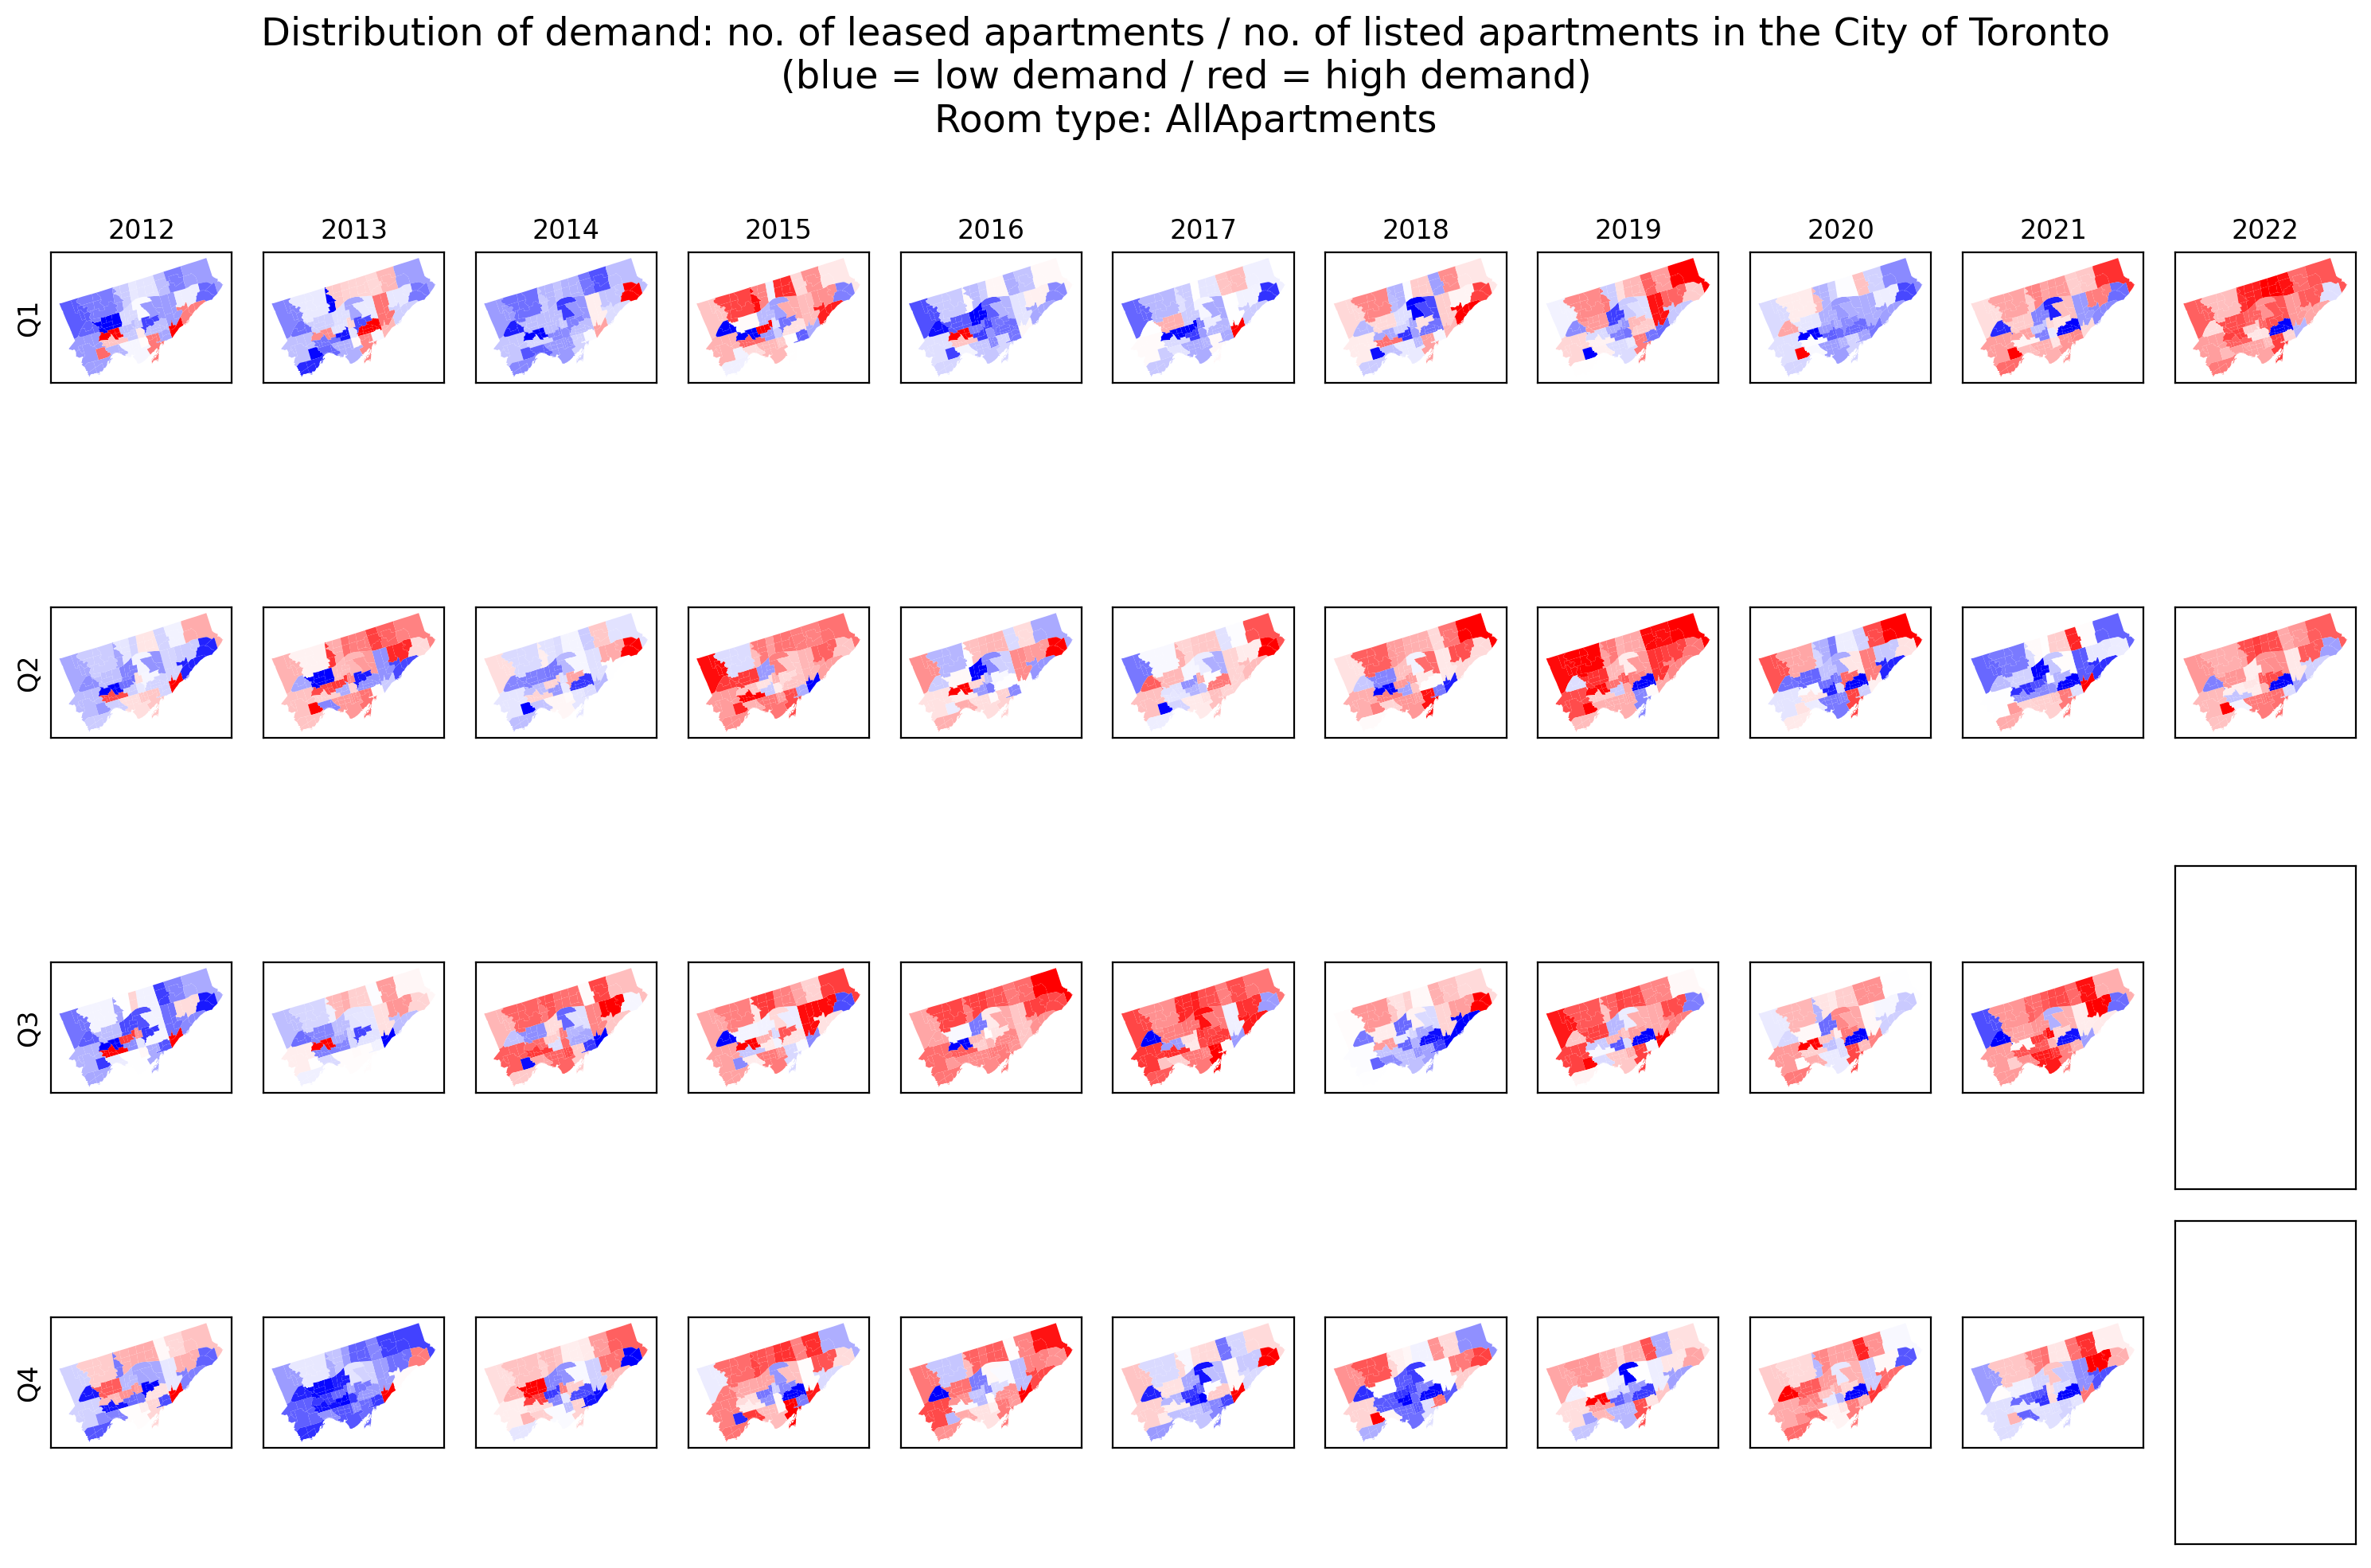

In [14]:
plot_rental('LeasedvsListed_AllApartments', 
            'Distribution of demand: no. of leased apartments / no. of listed apartments in the City of Toronto\n(blue = low demand / red = high demand)',
            'AllApartments')

# Plot trend in lease rate

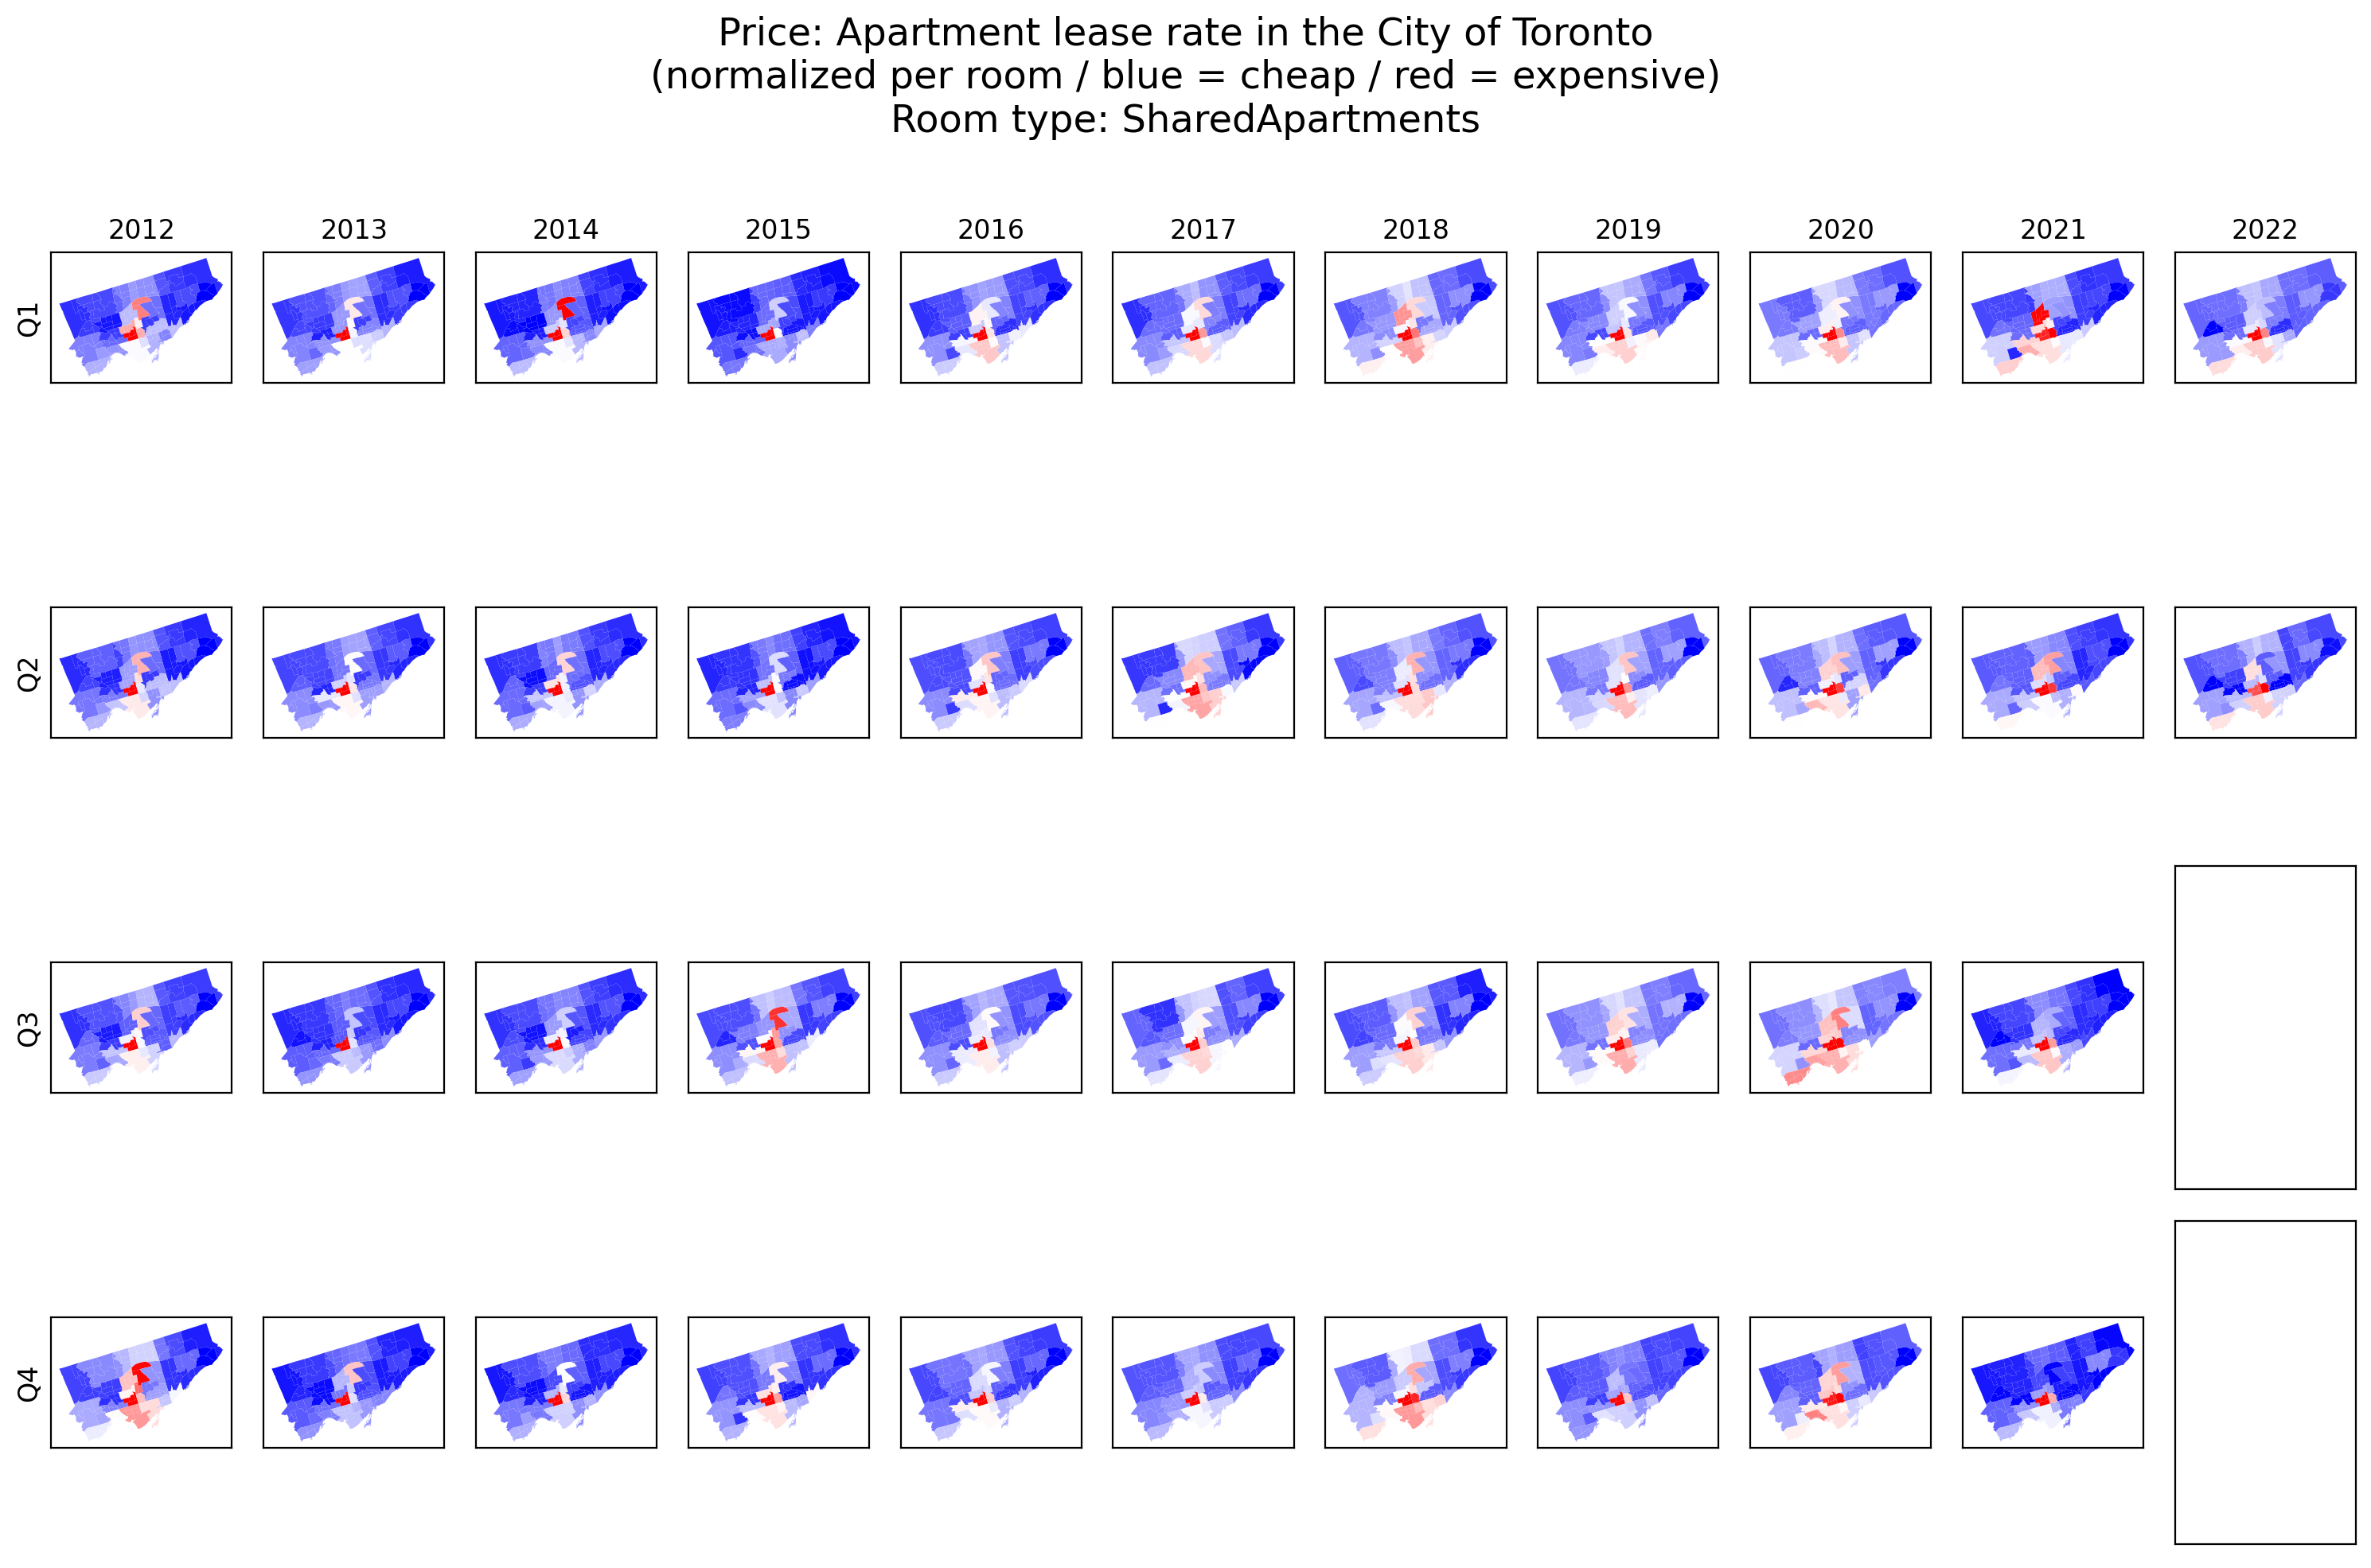

In [15]:
plot_rental('AvgLeaseRatePerRoom', 
            'Price: Apartment lease rate in the City of Toronto\n(normalized per room / blue = cheap / red = expensive)',
            'SharedApartments')

# Plot lease demand

Text(0.5, 1.0, 'Recovery in rental demand: ratio of leased to listed apartments has recovered in 2022 to pre-covid levels')

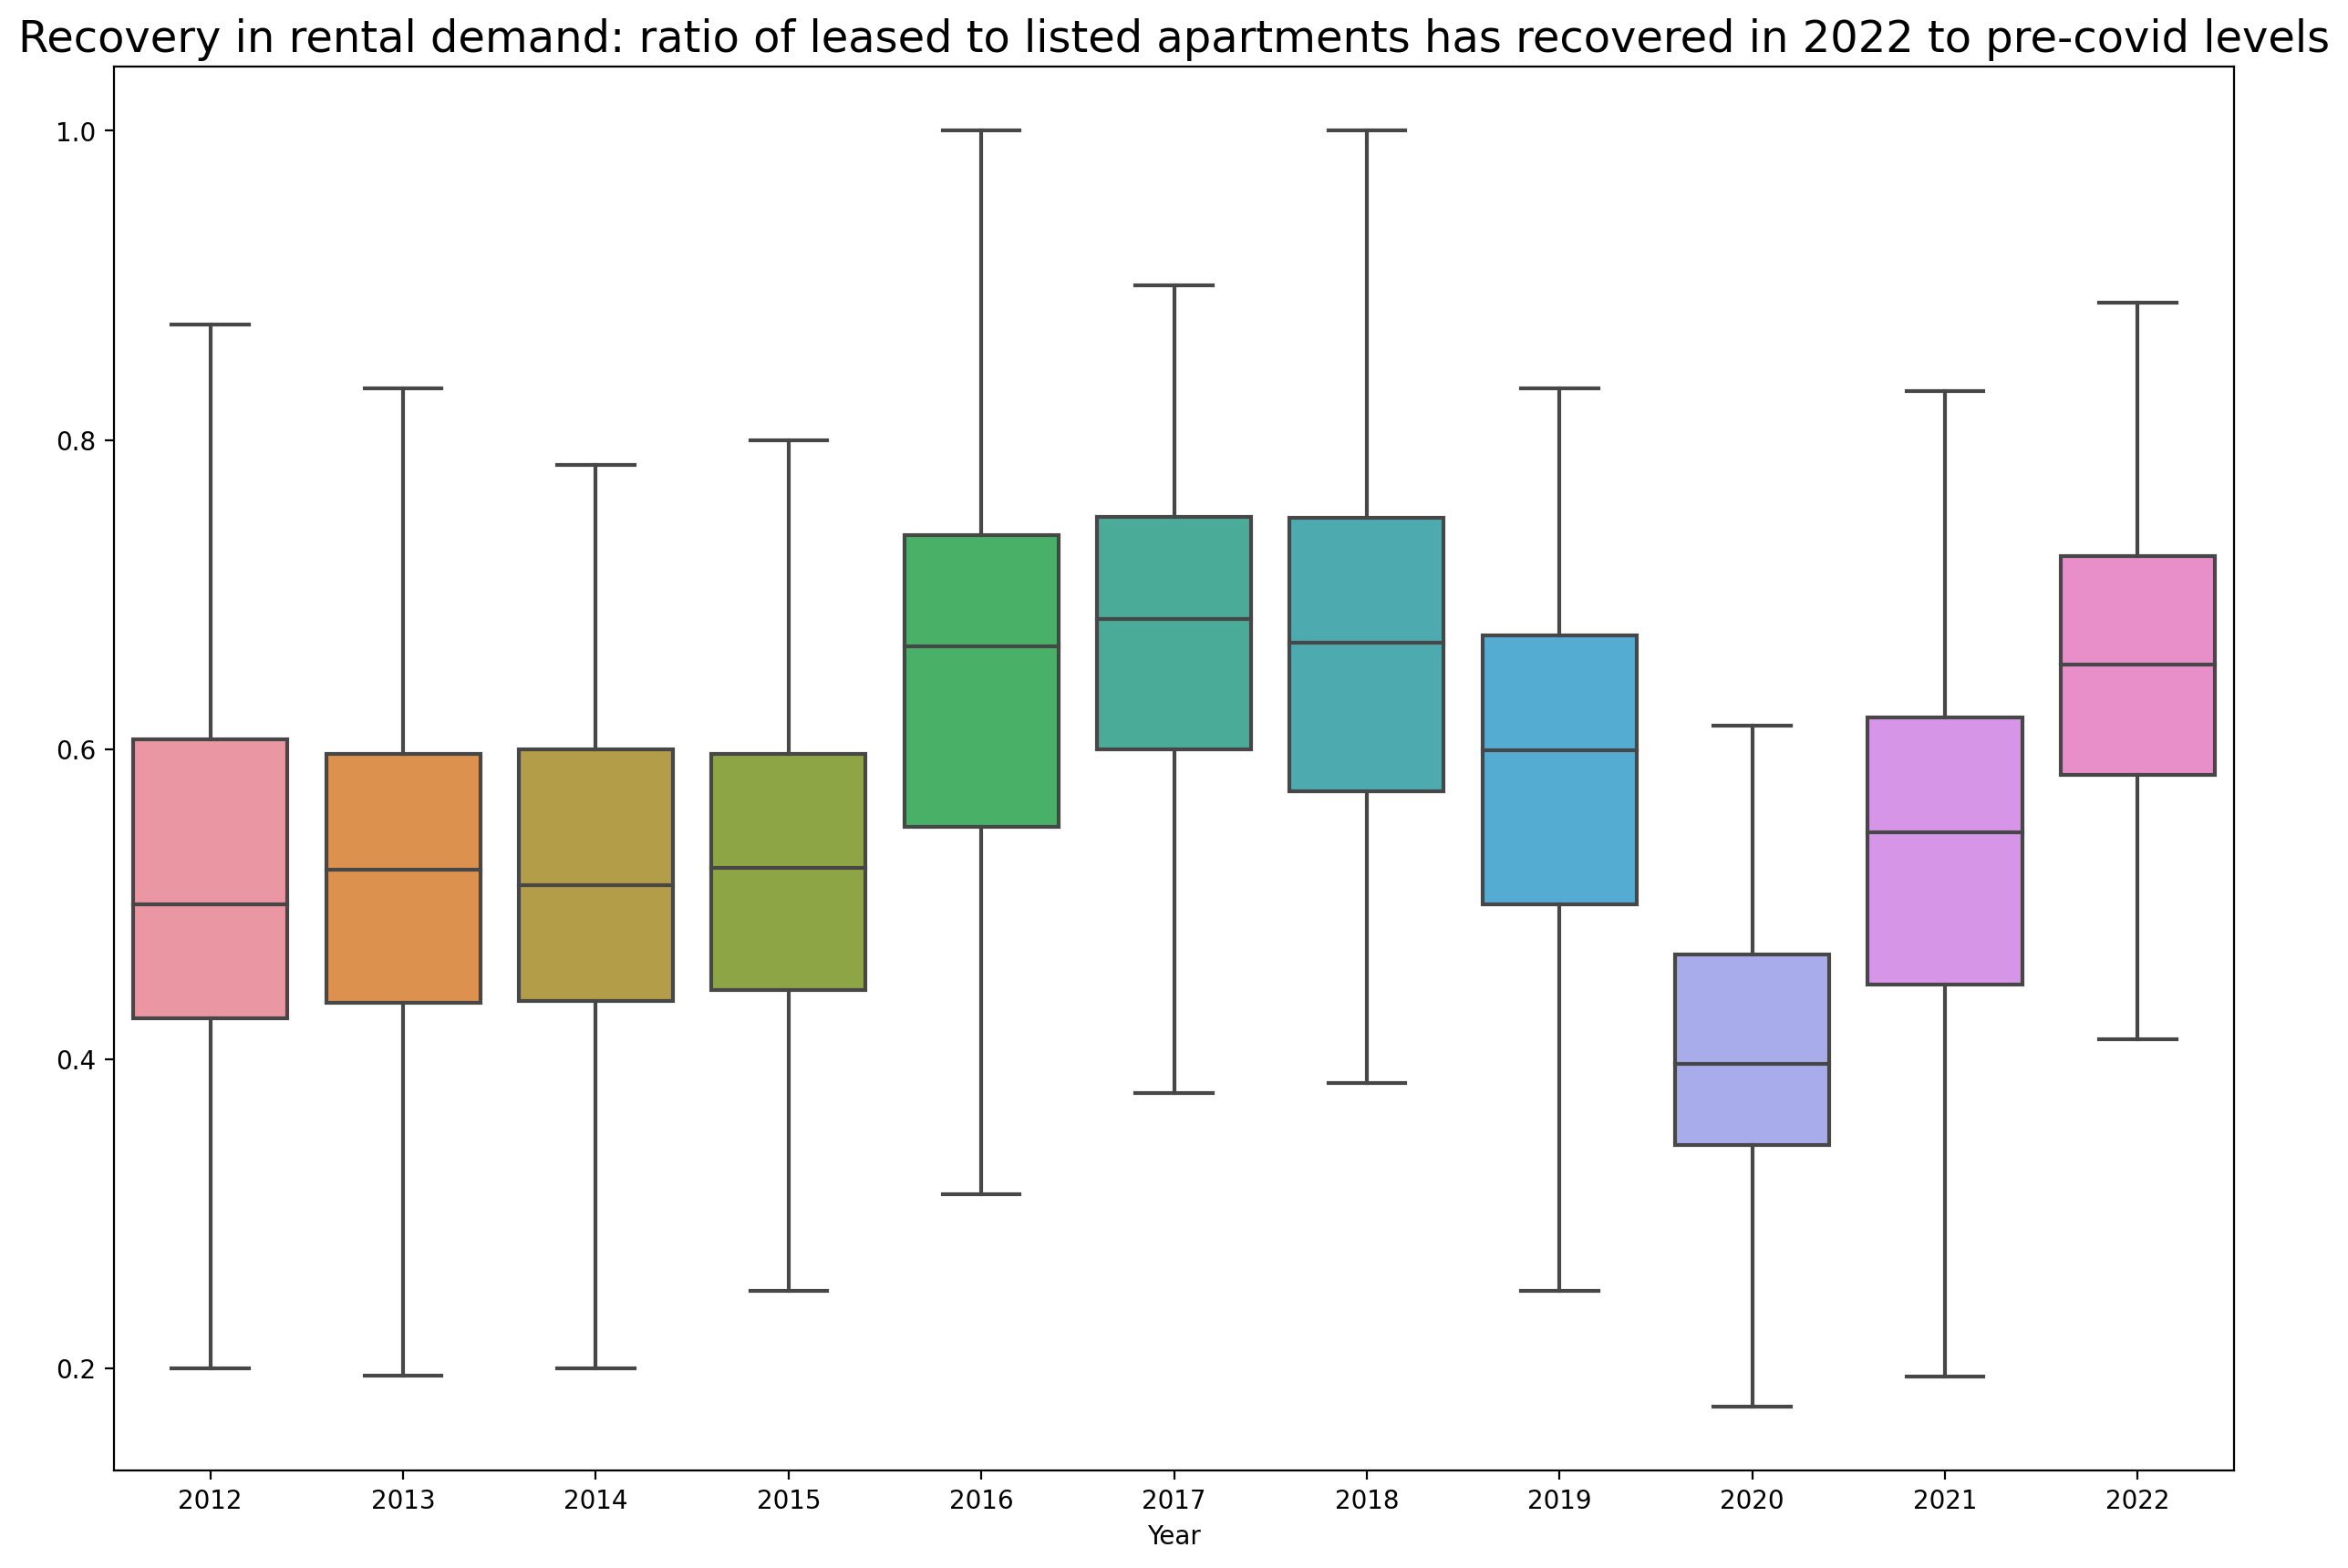

In [16]:
var = 'LeasedvsListed_AllApartments'
title = 'Recovery in rental demand: ratio of leased to listed apartments has recovered in 2022 to pre-covid levels'

ax = sns.boxplot(x='Year', y=var, data=neighbourhoods_rent, 
            showfliers = False, # remove outliers
            )
ax.set_ylabel('')
ax.set_title(title, size='xx-large')

# Yearly effect

Text(0.5, 1.1, 'Lease rates for apartments have recovered to pre-covid levels\n(normalized by number of rooms)')

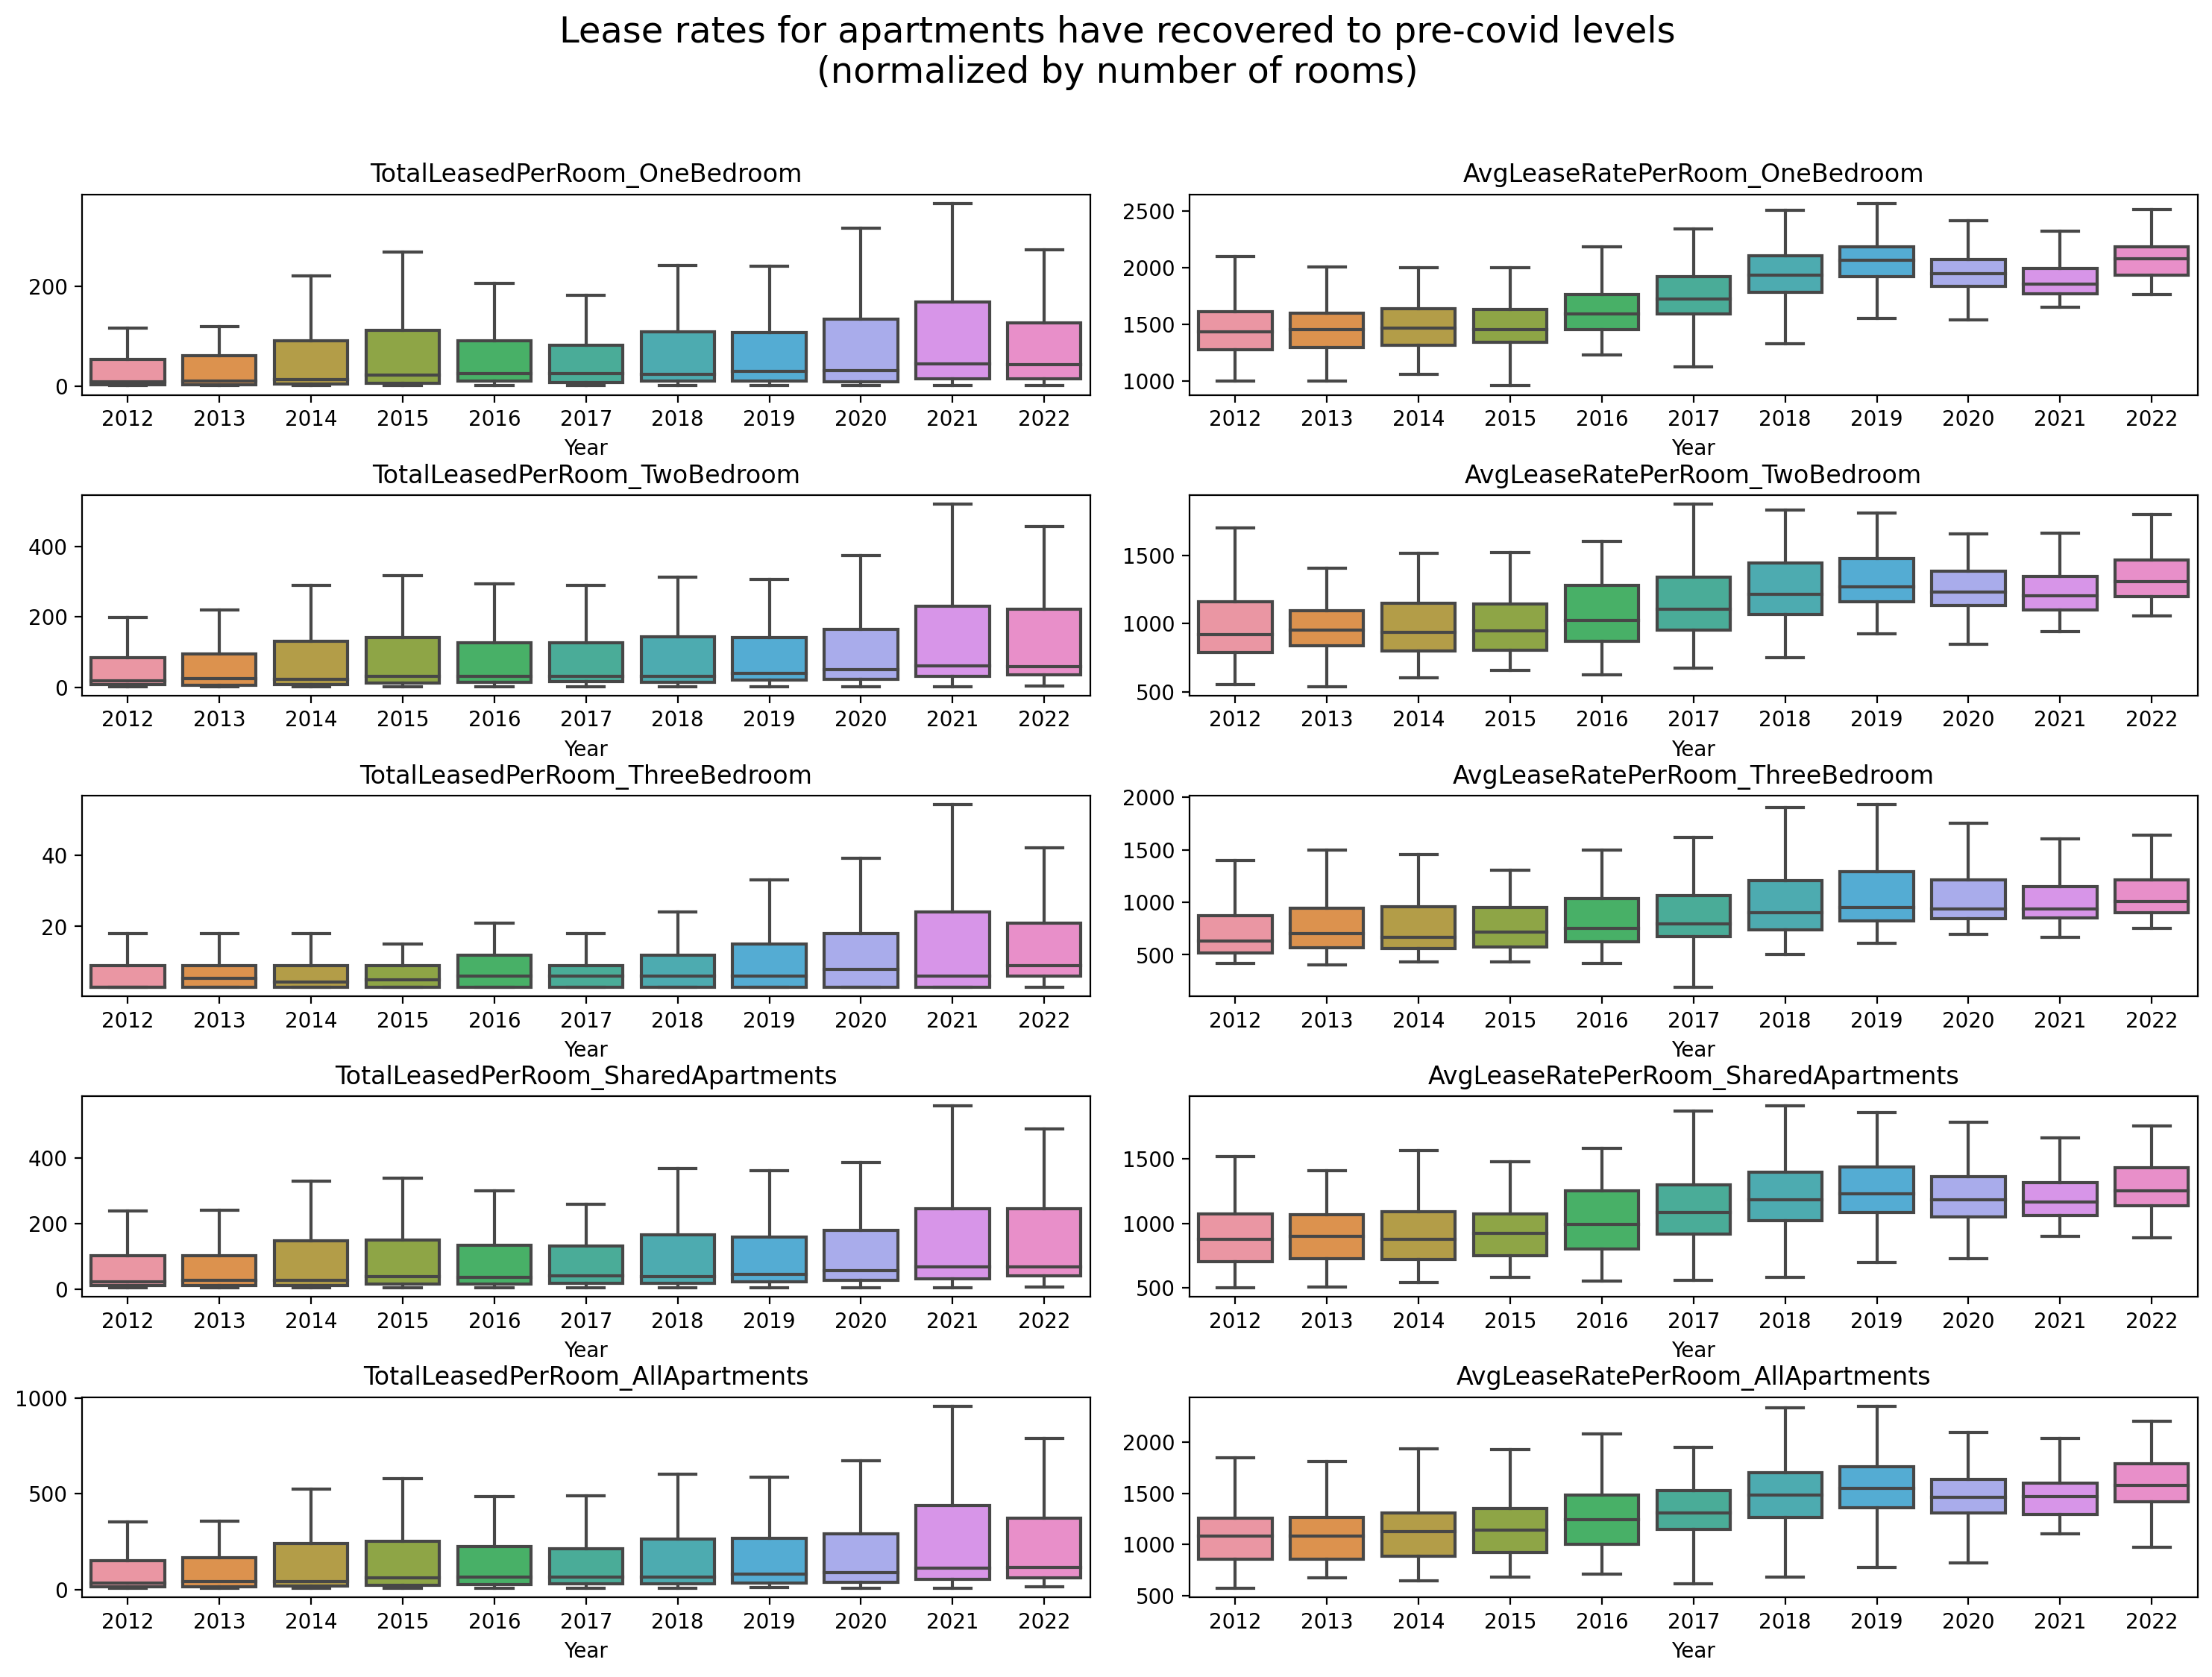

In [17]:
var1 = ['OneBedroom', 'TwoBedroom', 'ThreeBedroom', 'SharedApartments', 'AllApartments']
var2 = ['TotalLeasedPerRoom', 'AvgLeaseRatePerRoom']

fig, axes = plt.subplots(int(len(var1) * len(var2) / 2),2)
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for (v1, v2), ax in zip([(v1, v2) for v1 in var1 for v2 in var2], axes.flatten()):
    sns.boxplot(x='Year', y=v2, data=neighbourhoods_rent.loc[neighbourhoods_rent['RoomType'] == v1], 
                showfliers = False, # remove outliers
                ax=ax)
    ax.set_ylabel('')
    ax.set_title(v2 + '_' + v1)
    
fig.suptitle('Lease rates for apartments have recovered to pre-covid levels\n(normalized by number of rooms)', 
             size='xx-large', y = 1.1)

# Quarterly effect

Text(0.5, 1.1, 'Quarterly effect: lease rates are stable throughout the year despite strong demand in Q3 due to school season\n(normalized by number of rooms)')

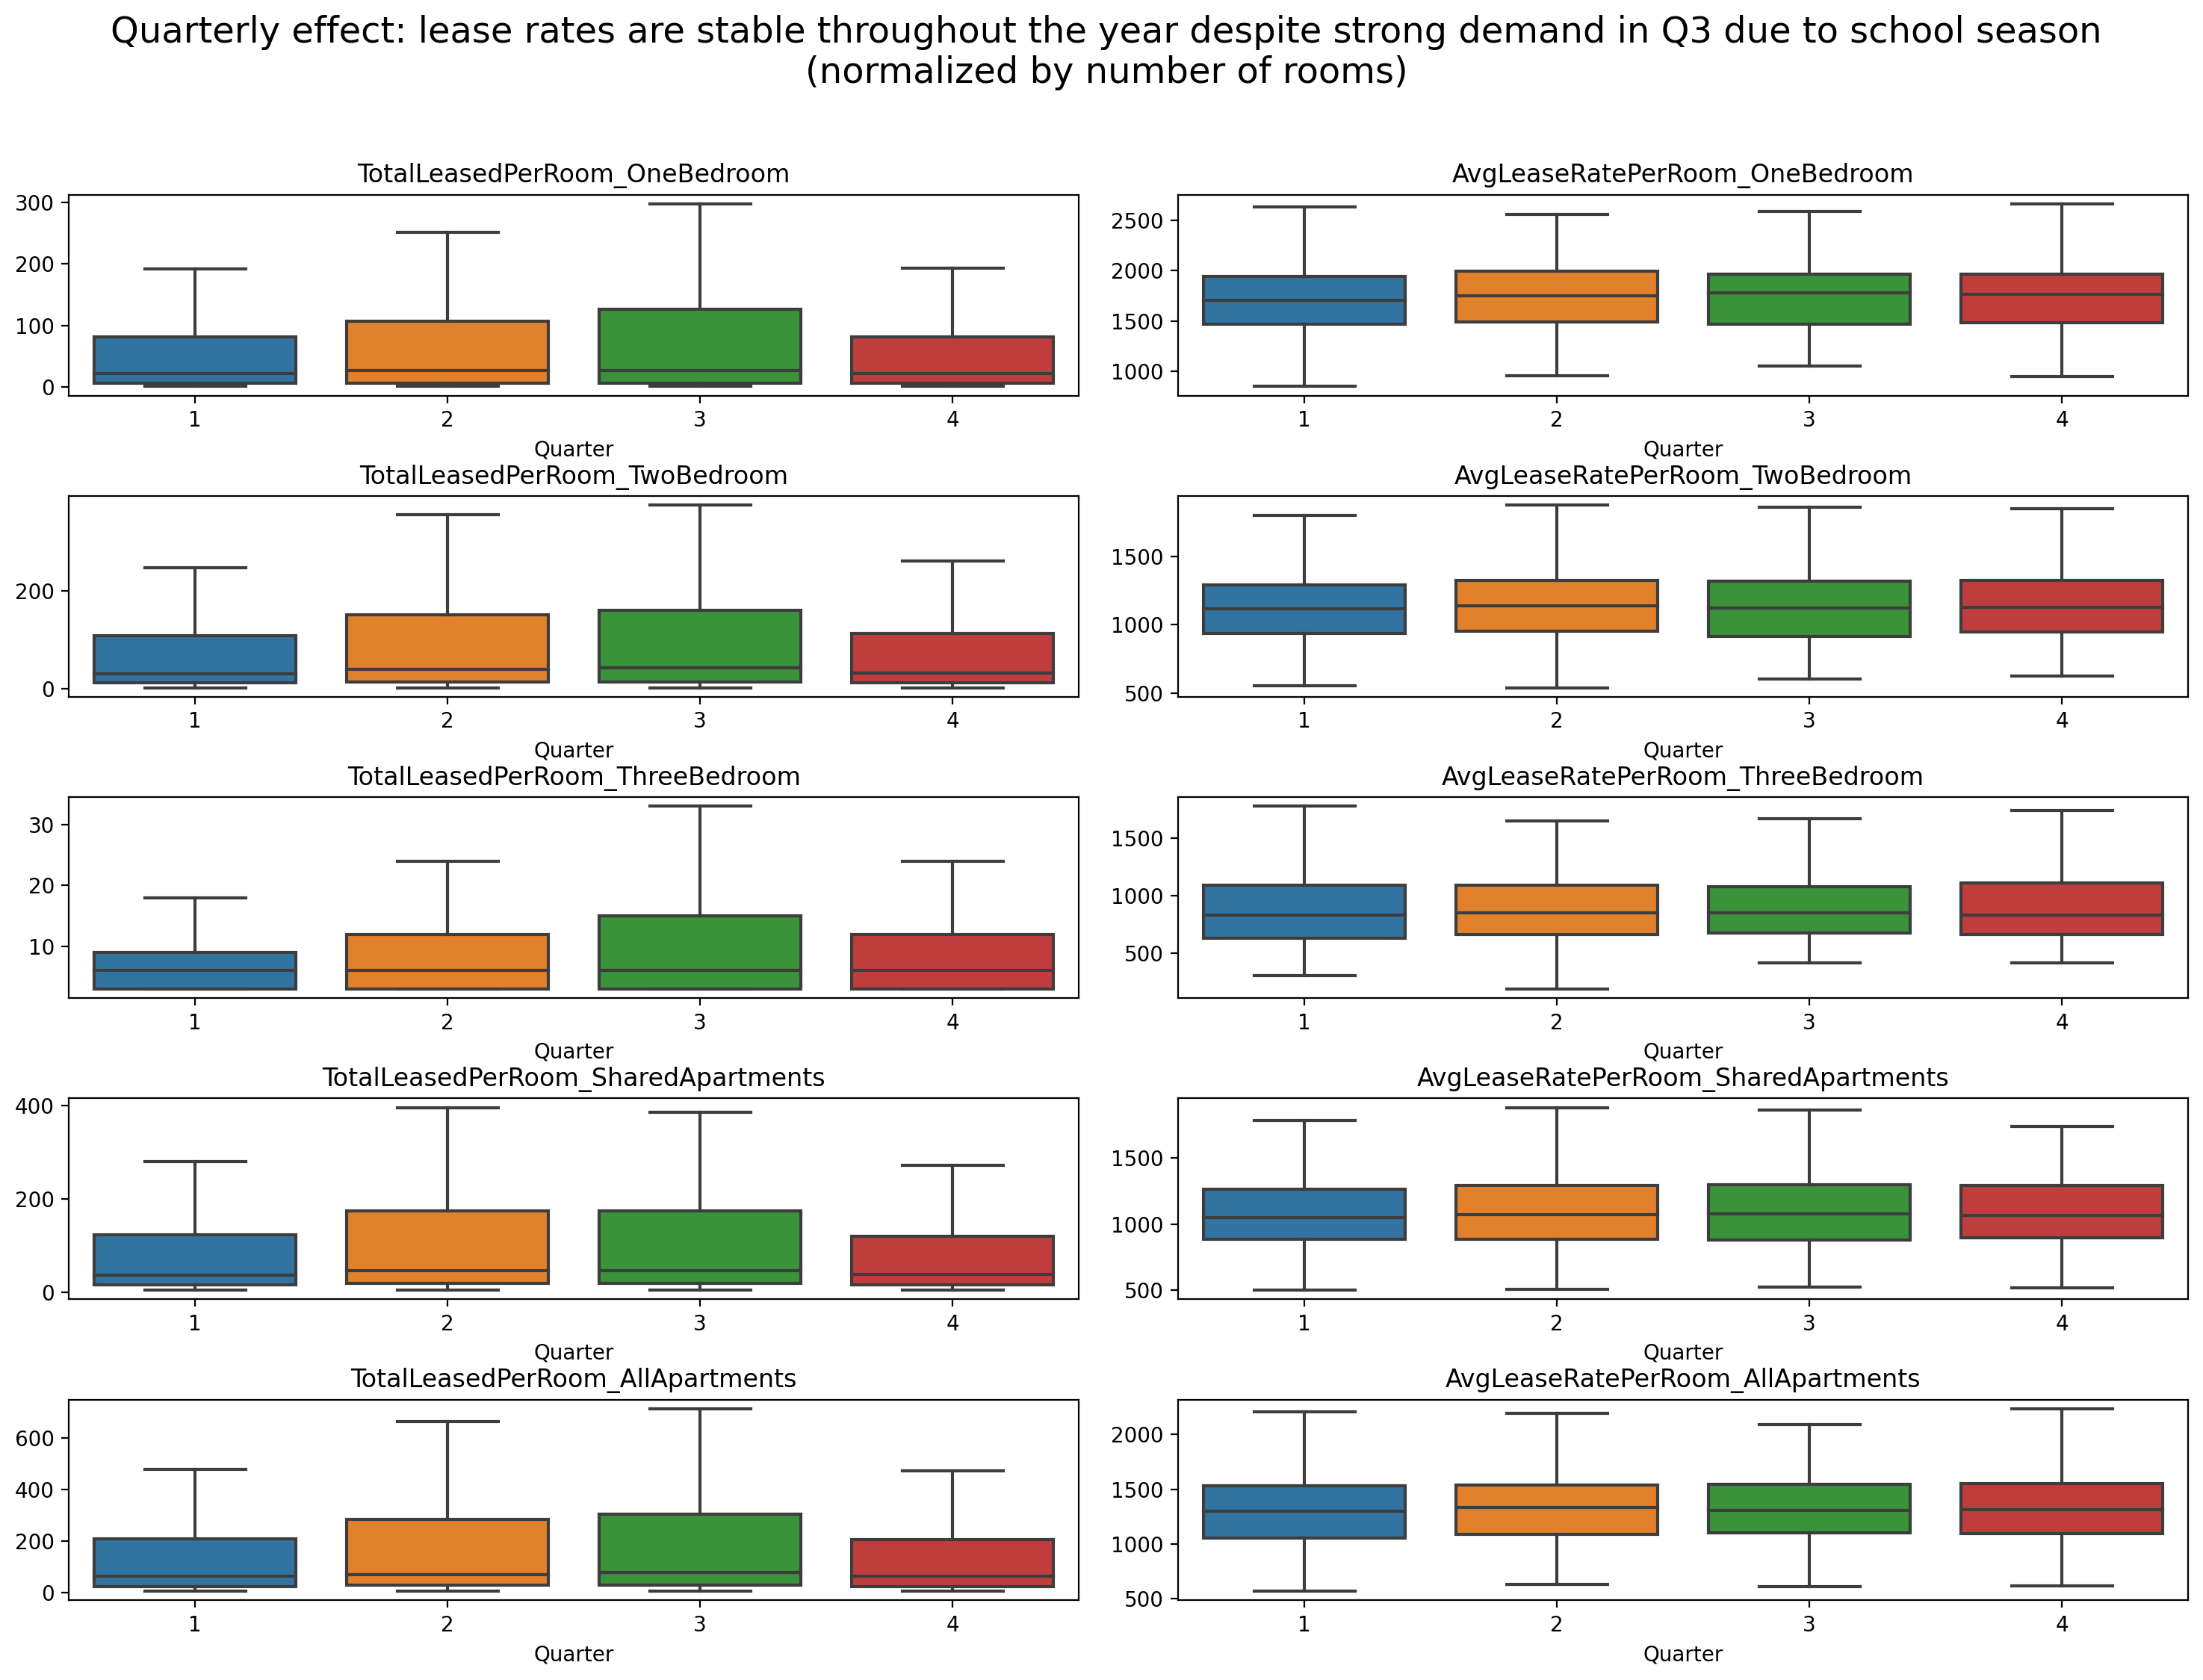

In [18]:
fig, axes = plt.subplots(int(len(var1) * len(var2) / 2),2)
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for (v1, v2), ax in zip([(v1, v2) for v1 in var1 for v2 in var2], axes.flatten()):
    sns.boxplot(x='Quarter', y=v2, data=neighbourhoods_rent.loc[neighbourhoods_rent['RoomType'] == v1], 
                showfliers = False, # remove outliers
                ax=ax)
    ax.set_ylabel('')
    ax.set_title(v2 + '_' + v1)
    
fig.suptitle('Quarterly effect: lease rates are stable throughout the year despite strong demand in Q3 due to school season\n(normalized by number of rooms)', 
             size='xx-large', y = 1.1)

# Plot all together

In [19]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')

Top 10 most expensive MLS districts: 
 neighbourhood            district
Rosedale-Moore Park      C09         2070.252242
Yonge-St.Clair           C02         2031.375124
Annex                    C02         2031.375124
Casa Loma                C02         2031.375124
Wychwood                 C02         2031.375124
University               C01         1824.904346
Palmerston-Little Italy  C01         1824.904346
Trinity-Bellwoods        C01         1824.904346
Bay Street Corridor      C01         1824.904346
Little Portugal          C01         1824.904346
Name: AvgLeaseRatePerRoom, dtype: float64


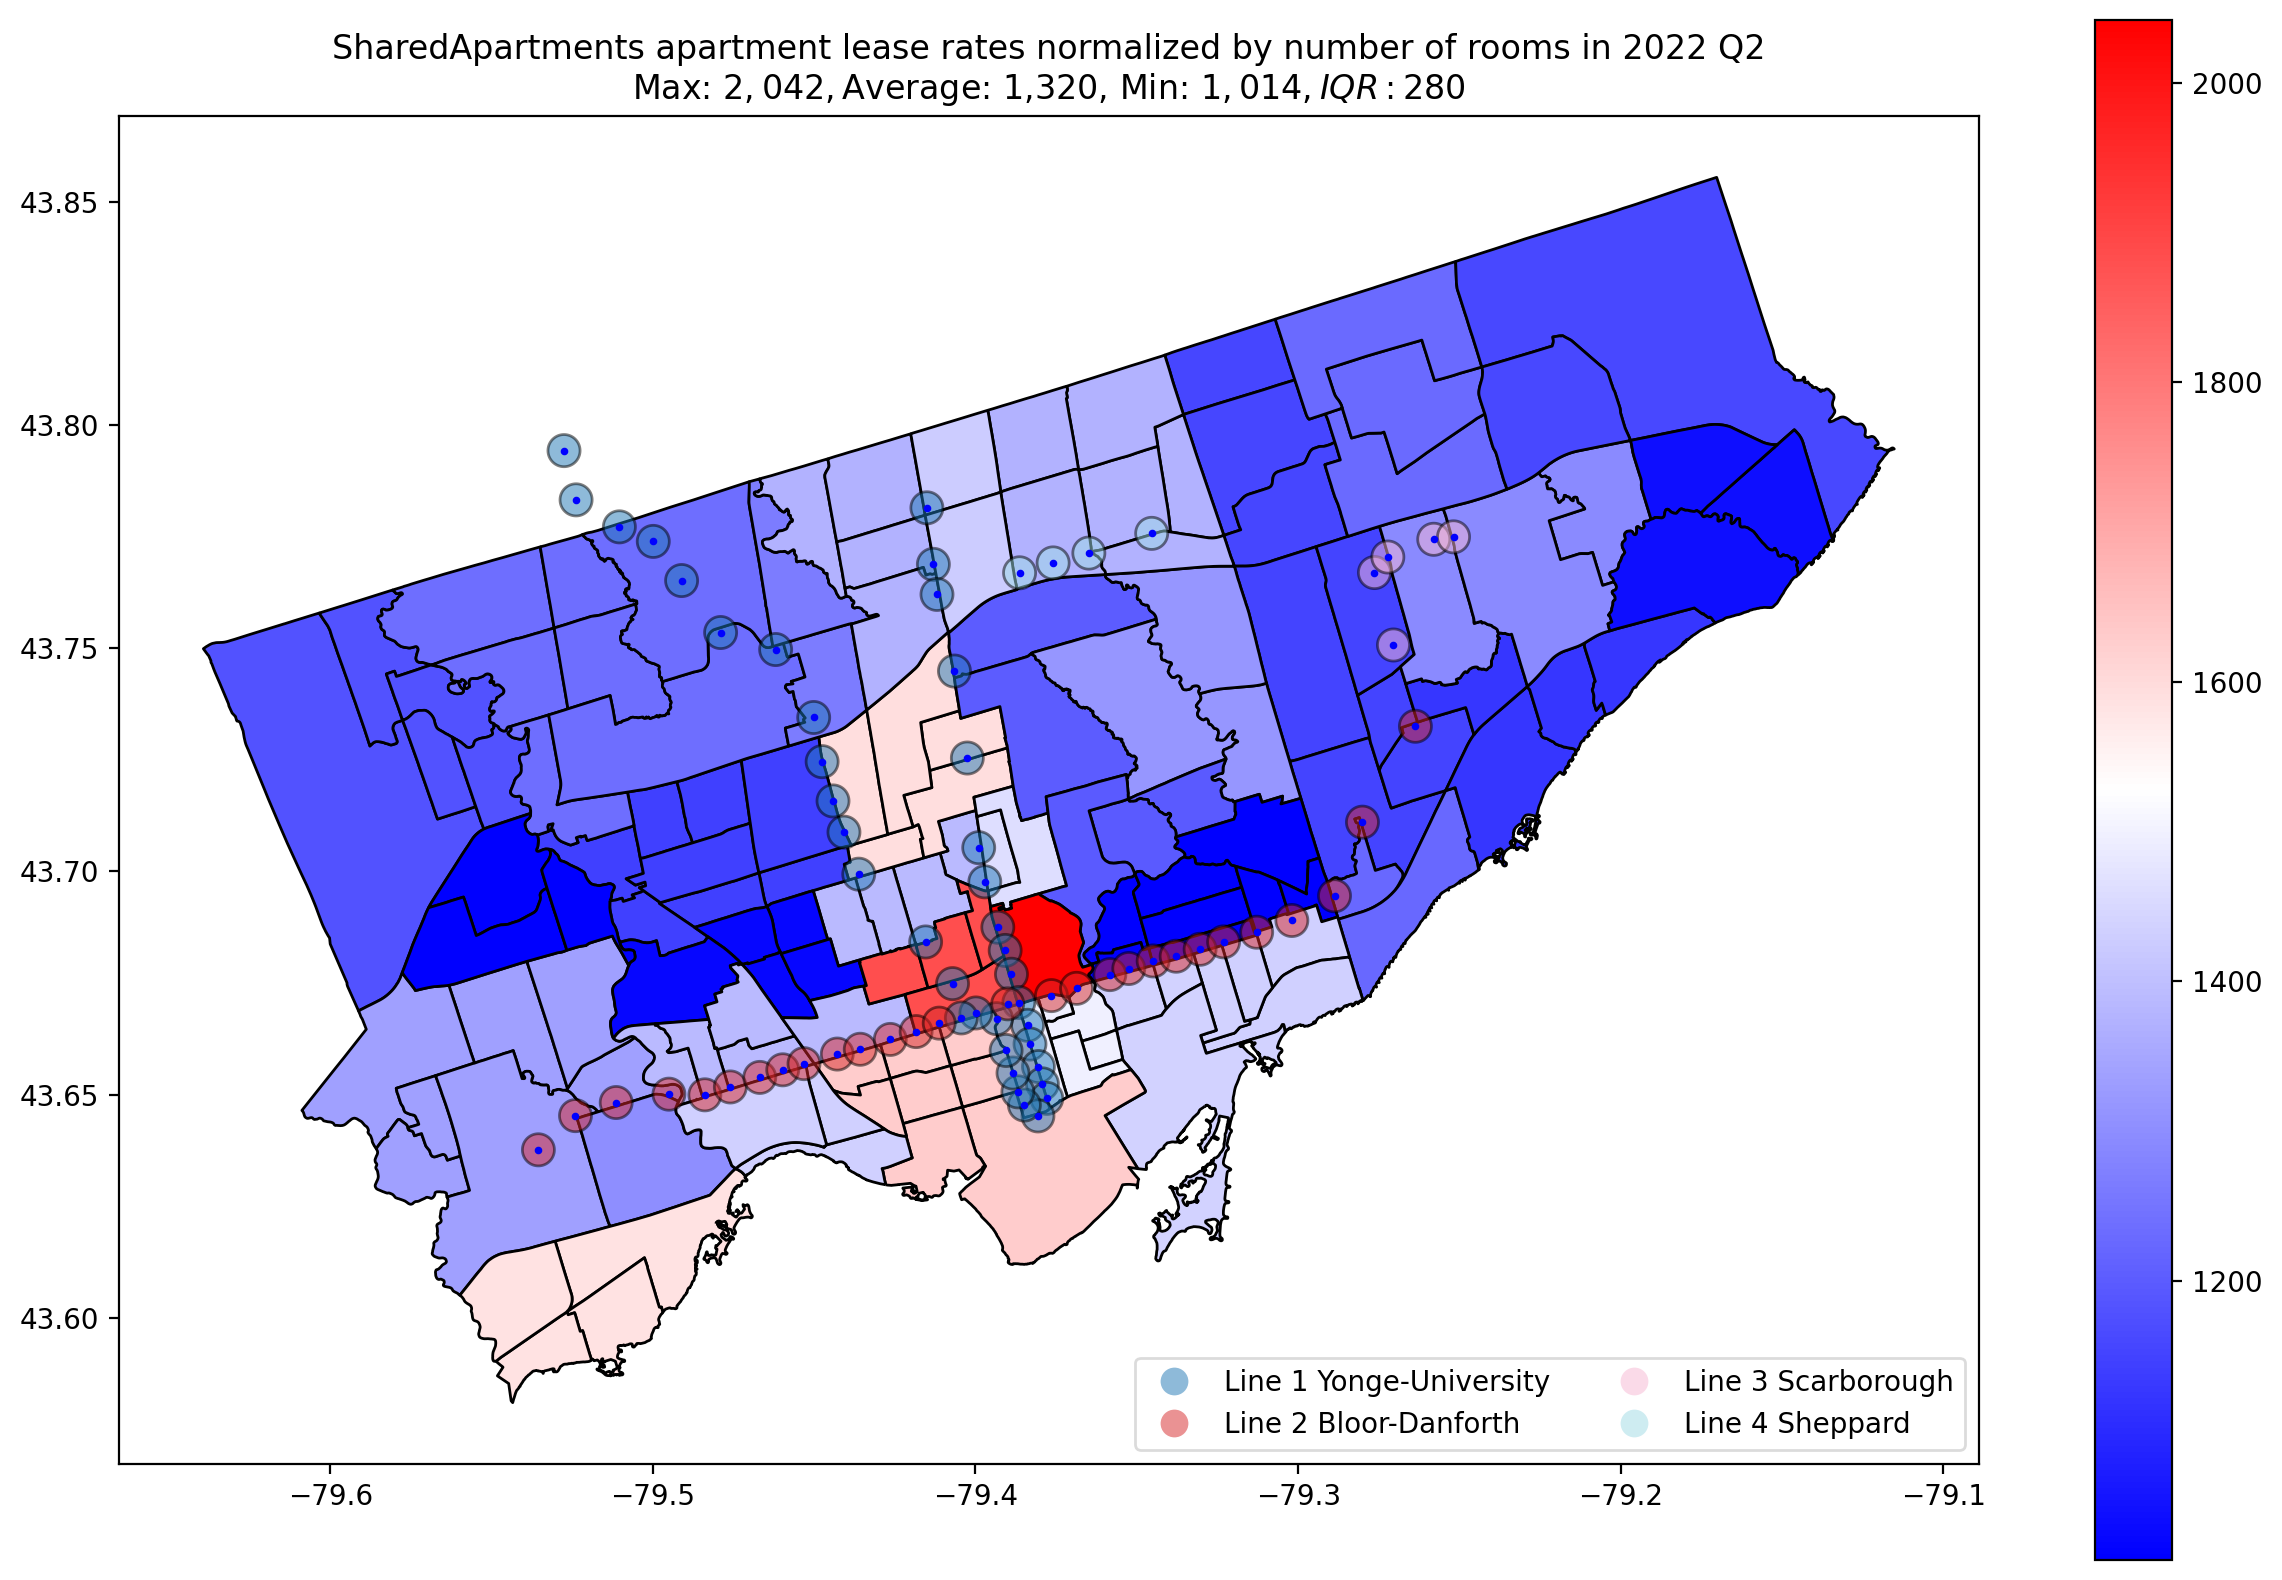

In [20]:
selected_year = 2022
selected_quarter = 2
var = 'AvgLeaseRatePerRoom'
room = 'SharedApartments'
selected_period = neighbourhoods_rent.loc[(neighbourhoods_rent['Year'] == selected_year) &
                                         (neighbourhoods_rent['Quarter'] == selected_quarter) &
                                         (neighbourhoods_rent['RoomType'] == room)]


ax = selected_period.plot(column = var,
                     legend = True,
                     edgecolor = 'black',
                     cmap = "bwr",
                     )

# annotate MLS districts
# for geometry, label in zip(selected_period.geometry, selected_period.district):
#     ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')
    
stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'lower right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

    
ax.set_title(f"{room} apartment lease rates normalized by number of rooms in {selected_year} Q{selected_quarter}\nMax: ${selected_period[var].max():,.0f}, $Average: {selected_period[var].mean():,.0f}, Min: ${selected_period[var].min():,.0f}, IQR: ${selected_period[var].quantile(0.75) - selected_period[var].quantile(0.25):,.0f}")

print("Top 10 most expensive MLS districts: \n",neighbourhoods_rent.loc[(neighbourhoods_rent['Year'] == selected_year) & (neighbourhoods_rent['Quarter'] == selected_quarter)].groupby(['neighbourhood', 'district'])[var].mean().sort_values(ascending=False).head(10))